Name: Muley, Tushar
Assignment: 13-1
Date: 15 November 2020

In [14]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [15]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

In [18]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [31]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [34]:
def EstimateMarriageSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [35]:
def ResampleSurvival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

In [40]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

Here are the results for the combined data.

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
def PlotPredictionsByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [49]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [114]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [115]:
# Quick peek at married6
married6

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,8.583333,21.583333
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,2.333333,27.000000
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,24.750000
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,19.500000
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,23.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7634,1282,798,True,1057.0,1119.0,2,4055.209574,1228,21.583333,35.833333,66,6,13,0,5.166667,14.250000
7635,2954,862,True,1069.0,NaN,1,4087.693768,1228,17.250000,30.500000,71,7,14,1,NaN,13.250000
7636,4964,727,True,953.0,NaN,6,3703.220316,1227,18.833333,41.666667,60,6,12,1,NaN,22.833333
7637,143,808,True,1060.0,1151.0,0,4496.050707,1230,21.000000,35.166667,67,6,13,0,7.583333,14.166667


In [119]:
#Compute the duration of marriages that have ended in divorce, and the duration, so far, 
#of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

complete6 = married6[married6.notdivorced!=1].durationsofar.dropna()
ongoing6 = married6[married6.evrmarry==1].durationsofar.dropna()

complete7 = married7[married7.notdivorced!=1].durationsofar.dropna()
ongoing7 = married7[married7.evrmarry==1].durationsofar.dropna()

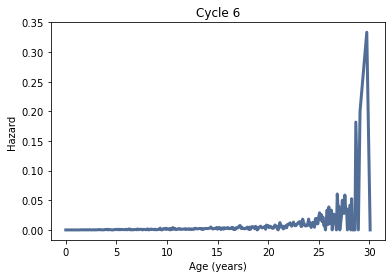

In [120]:
# Estimated hazard Cycle 6
hf = EstimateHazardFunction(complete6, ongoing6)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard',
                title = 'Cycle 6')


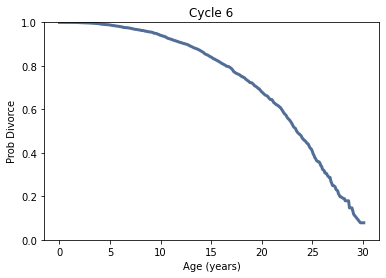

In [121]:
# Survival curve Cycle 6
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob Divorce',
                 ylim=[0, 1],
                title = 'Cycle 6')

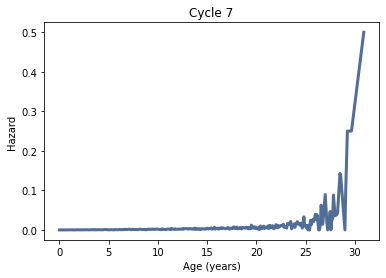

In [77]:
#Estimated hazard Cycle 7
hf = EstimateHazardFunction(complete7, ongoing7)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard',
                title = 'Cycle 7')

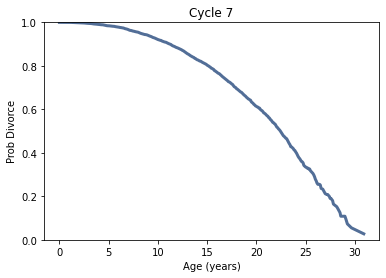

In [108]:
# Survival curve Cycle 7
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob Divorce',
                 ylim=[0, 1],
                title = 'Cycle 7')

In [56]:
# Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling
#error.

def ResampledDivorce(resps iters=15):

    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorce(sample) #color='#225EA8', alpha=0.1)
        
    thinkplot.Show(xlabel='Years', axis= [0,30,0,1])


In [101]:
#Solution
def ResampleDivorceByDecade(resps, iters=15):
    """resps: list of DataFrames 
        iters: number of resamples to plot"""
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
            for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.1) #0.7

        EstimateSurvivalInDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction Not Divorced',
                     axis=[0, 30, 0, 1])

In [125]:
def EstimateInDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [130]:
def EstimateSurvival(resp):

    complete = resp[resp.notdivorced!=1].duration.dropna()
    ongoing = resp[resp.notdivorced==1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

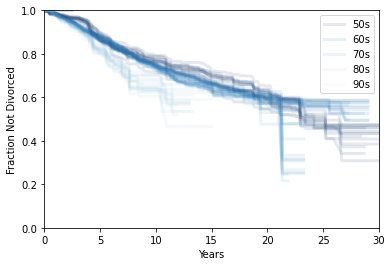

In [131]:
ResampleDivorceByDecade([married6, married7])
#Odd that they just drop like that.